In [1]:
import os 
import timm
import torch
import torch
import torch.nn as nn
import requests
import timm
import math
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from lightly.data.dataset import LightlyDataset

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
from multissl.models import PasiphaeUPerNetModule, PasiphaeUPerNet, MSRGBConvNeXtUPerNet, MSRGBConvNeXtUPerNetModule
from multissl.plotting.rgb_batch import rgb_visualize_batch

In [146]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import pytorch_lightning as pl
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
from tqdm import tqdm

class COCOSegmentationDataset(Dataset):
    """
    Dataset for loading a COCO image with its segmentation mask
    """
    def __init__(self, coco_json_path, img_dir, transform=None, target_transform=None):
        """
        Args:
            coco_json_path: Path to COCO JSON annotations file
            img_dir: Directory with the images
            transform: Optional transform for the image
            target_transform: Optional transform for the mask
        """
        self.coco = COCO(coco_json_path)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
        # Get all image ids with segmentation annotations
        self.img_ids = list(self.coco.imgs.keys())
        
        # Filter ids to ensure each image has segmentation annotations
        self.img_ids = [img_id for img_id in self.img_ids 
                        if len(self.coco.getAnnIds(imgIds=img_id, iscrowd=None)) > 0]
        
        # Get category information
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.category_names = {cat['id']: cat['name'] for cat in self.categories}
        self.num_classes = len(self.categories) + 1  # +1 for background
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        """
        Get image and mask for a given index
        
        Args:
            idx: Index to retrieve
            
        Returns:
            dict: Contains RGB image and segmentation mask
        """
        img_id = self.img_ids[idx]
        
        # Load image information
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Load RGB image
        image = Image.open(image_path).convert("RGB")
        
        # Create segmentation mask
        mask = self.create_mask(img_id, img_info['height'], img_info['width'])
        
        # Apply transforms
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        else:
            # Convert mask to tensor if no transform is specified
            mask = torch.from_numpy(mask).long()
        
        return {'rgb': image, 'mask': mask, 'img_id': img_id}
    
    def create_mask(self, img_id, height, width):
        """
        Create a segmentation mask for a given image
        
        Args:
            img_id: Image ID
            height, width: Dimensions of the image
            
        Returns:
            mask: Segmentation mask where each pixel value corresponds to a class ID
        """
        # Initialize empty mask with zeros (background)
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # Get annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        annotations = self.coco.loadAnns(ann_ids)
        
        # Sort annotations by area (to handle overlapping masks)
        annotations = sorted(annotations, key=lambda x: x['area'], reverse=True)
        
        # Add each annotation to the mask
        for ann in annotations:
            # Convert COCO format to binary mask
            binary_mask = self.coco.annToMask(ann)
            
            # Set pixels in the binary mask to corresponding category ID
            # Add 1 to category ID because 0 is reserved for background
            mask[binary_mask == 1] = ann['category_id']
        
        return mask
    
    def visualize_item(self, idx):
        """
        Visualize an image and its segmentation mask
        
        Args:
            idx: Index to visualize
            
        Returns:
            Displays the image and mask
        """
        item = self[idx]
        image = item['rgb']
        mask = item['mask']
        img_id = item['img_id']
        
        # Convert tensor to numpy for visualization
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
            # Normalize to [0, 1] if needed
            if image.max() > 1.0 or image.min() < 0.0:
                image = (image - image.min()) / (image.max() - image.min())
        
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()
        
        # Create a color map for the mask
        # This is a simple color map where each class gets a different color
        cmap = plt.cm.get_cmap('tab20', self.num_classes)
        colored_mask = cmap(mask)
        
        # Plot the image and mask
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot image
        axes[0].imshow(image)
        axes[0].set_title(f'Image (ID: {img_id})')
        axes[0].axis('off')
        
        # Plot mask
        axes[1].imshow(colored_mask)
        axes[1].set_title('Segmentation Mask')
        axes[1].axis('off')
        
        # Add annotation for each class in the mask
        unique_classes = np.unique(mask)
        legend_elements = []
        for cls in unique_classes:
            if cls == 0:
                name = 'Background'
            else:
                name = self.category_names.get(cls, f'Class {cls}')
            legend_elements.append(plt.Rectangle((0, 0), 1, 1, color=cmap(cls), label=name))
        
        axes[1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
        
        plt.tight_layout()
        plt.show()
        
def create_center_heatmap_tensor(instance_masks, sigma=2.0):
    """
    Create a center point heatmap from instance mask tensors
    
    Args:
        instance_masks: Tensor of shape [num_instances, H, W] with binary masks
        sigma: Standard deviation for Gaussian peaks
        
    Returns:
        Center heatmap tensor [H, W]
    """
    if instance_masks.shape[0] == 0:
        return torch.zeros((instance_masks.shape[1], instance_masks.shape[2]), 
                          device=instance_masks.device)
    
    num_instances, h, w = instance_masks.shape
    heatmap = torch.zeros((h, w), device=instance_masks.device)
    
    for mask in instance_masks:
        # Find center of mass of the instance
        y_indices, x_indices = torch.where(mask > 0.5)
        if len(y_indices) == 0:
            continue
            
        center_y = torch.mean(y_indices.float()).round().long()
        center_x = torch.mean(x_indices.float()).round().long()
        
        # Create meshgrid for distance calculation
        y = torch.arange(h, device=instance_masks.device)
        x = torch.arange(w, device=instance_masks.device)
        y_grid, x_grid = torch.meshgrid(y, x, indexing='ij')
        
        # Calculate squared distance
        dist_sq = (y_grid - center_y) ** 2 + (x_grid - center_x) ** 2
        
        # Create Gaussian
        gaussian = torch.exp(-dist_sq / (2 * sigma ** 2))
        
        # Add to heatmap (maximum)
        heatmap = torch.maximum(heatmap, gaussian)
    
    return heatmap

def create_boxes_from_masks_tensor(instance_masks):
    """
    Create bounding boxes from instance mask tensors
    
    Args:
        instance_masks: Tensor of shape [num_instances, H, W] with binary masks
        
    Returns:
        Tensor of boxes with shape [num_instances, 4] in format [x1, y1, x2, y2]
    """
    num_instances = instance_masks.shape[0]
    boxes = torch.zeros((num_instances, 4), device=instance_masks.device)
    
    for i, mask in enumerate(instance_masks):
        # Find non-zero indices
        y_indices, x_indices = torch.where(mask > 0.5)
        if len(y_indices) == 0:
            # Empty mask, add a dummy box
            boxes[i] = torch.tensor([0, 0, 1, 1], device=instance_masks.device)
            continue
            
        # Get bounding box coordinates
        y1, y2 = torch.min(y_indices), torch.max(y_indices)
        x1, x2 = torch.min(x_indices), torch.max(x_indices)
        
        # Add box in [x1, y1, x2, y2] format
        boxes[i] = torch.tensor([x1, y1, x2, y2], device=instance_masks.device)
    
    return boxes
    

def prepare_instance_segmentation_batch(semantic_mask, instance_masks, class_ids, num_classes):
    """
    Prepare data for instance segmentation training
    
    Args:
        semantic_mask: Numpy array [H, W] with semantic class indices
        instance_masks: List of binary numpy arrays [H, W], one per instance
        class_ids: List of class IDs for each instance
        num_classes: Number of semantic classes
        
    Returns:
        Dictionary with prepared tensors
    """
    # One-hot encode semantic mask
    semantic_one_hot = one_hot_encode(semantic_mask, num_classes)
    
    # Convert instance masks to tensor
    instance_tensor = binary_masks_to_tensor(instance_masks)
    
    # Convert class IDs to tensor
    class_tensor = torch.tensor(class_ids, dtype=torch.long)
    
    # Create center points heatmap (could be derived from instance masks)
    centers_heatmap = create_center_heatmap(instance_masks, sigma=2.0)  # Implementation depends on your approach
    
    # Create bounding boxes from instance masks
    boxes = create_boxes_from_masks(instance_masks)  # Implementation depends on your approach
    
    return {
        'semantic_mask': torch.from_numpy(semantic_mask).long(),  # Original class indices
        'semantic_one_hot': semantic_one_hot,                      # One-hot encoded
        'instance_masks': instance_tensor,
        'instance_classes': class_tensor,
        'centers': centers_heatmap,
        'boxes': boxes
    }
    
def one_hot_encode(mask, num_classes):
    """
    Convert a single-channel class index mask to one-hot format
    
    Args:
        mask: Numpy array of shape [H, W] with integer class indices
        num_classes: Number of classes to encode
        
    Returns:
        One-hot encoded tensor of shape [num_classes, H, W]
    """
    # Convert numpy array to torch tensor if it's not already
    if isinstance(mask, np.ndarray):
        mask = torch.from_numpy(mask).long()
    else:
        mask = mask.long()
    
    # Create one-hot encoding
    one_hot = torch.zeros((num_classes, *mask.shape), dtype=torch.float32)
    one_hot.scatter_(0, mask.unsqueeze(0), 1.0)
    
    return one_hot
    
def instance_id_to_one_hot(instance_map, max_instances=1000):
    """
    Convert an instance ID map to one-hot encoding
    
    Args:
        instance_map: Numpy array of shape [H, W] with integer instance IDs (0 is background)
        max_instances: Maximum number of instances to encode
        
    Returns:
        One-hot encoded tensor of shape [max_instances, H, W]
    """
    # Ensure we don't exceed max_instances
    instance_map = np.clip(instance_map, 0, max_instances)
    
    # Convert to tensor
    instance_map = torch.from_numpy(instance_map).long()
    
    # Create one-hot encoding (including background as first channel)
    one_hot = torch.zeros((max_instances + 1, *instance_map.shape), dtype=torch.float32)
    one_hot.scatter_(0, instance_map.unsqueeze(0), 1.0)
    
    # Remove background channel (index 0) if not needed
    one_hot = one_hot[1:, :, :]  # Shape: [max_instances, H, W]
    
    return one_hot

def instance_id_tensor_to_binary_masks(instance_tensor, ignore_zero=True):
    """
    Convert an instance ID tensor to separate binary masks for each instance
    
    Args:
        instance_tensor: Tensor of shape [H, W] with integer instance IDs
        ignore_zero: Whether to ignore 0 (typically background)
        
    Returns:
        Binary masks tensor of shape [num_instances, H, W]
    """
    # Get unique instance IDs
    # Check if batch dimension exists
    has_batch_dim = instance_tensor.dim() == 3
    
    if has_batch_dim:
        # Add batch dimension for processing
        instance_tensor = instance_tensor.squeeze(0)
        
    instance_ids = torch.unique(instance_tensor)
    
    # Remove background ID (0) if needed
    if ignore_zero and 0 in instance_ids:
        instance_ids = instance_ids[instance_ids != 0]
    
    # Create binary mask for each instance
    binary_masks = []
    for instance_id in instance_ids:
        binary_mask = (instance_tensor == instance_id).float()
        binary_masks.append(binary_mask)
    
    # Stack masks along first dimension
    if binary_masks:
        return torch.stack(binary_masks, dim=0)
    else:
        # Return empty tensor with correct shape if no instances
        return torch.zeros((0, *instance_tensor.shape), device=instance_tensor.device)

def prepare_instance_tensors(semantic_tensor, instance_tensor, class_ids_tensor=None, num_classes=2):
    """
    Prepare tensor data for instance segmentation training
    
    Args:
        semantic_tensor: Tensor [H, W] with semantic class indices
        instance_tensor: Tensor [H, W] with instance IDs, or [N, H, W] with binary masks
        class_ids_tensor: Tensor of class IDs for each instance, or None to derive from semantic mask
        num_classes: Number of semantic classes
        
    Returns:
        Dictionary with prepared tensors
    """
    instance_masks = instance_id_tensor_to_binary_masks(instance_tensor)

    num_instances = instance_masks.shape[0]
    
    # One-hot encode semantic mask
    semantic_one_hot = one_hot_encode_tensor(semantic_tensor, num_classes)
    
    # Determine class IDs if not provided
    if class_ids_tensor is None and num_instances > 0:
        # Derive class IDs from semantic mask and instance masks
        class_ids = []
        for instance_mask in instance_masks:
            # Find most common class in this instance region
            masked_semantic = semantic_tensor[instance_mask > 0.5]
            if masked_semantic.numel() > 0:
                most_common_class = torch.mode(masked_semantic).values
                class_ids.append(most_common_class)
            else:
                class_ids.append(torch.tensor(0, device=semantic_tensor.device))
        
        class_ids_tensor = torch.stack(class_ids)
    
    # Create center points heatmap
    centers_heatmap = create_center_heatmap_tensor(instance_masks)
    
    # Create bounding boxes
    boxes = create_boxes_from_masks_tensor(instance_masks)


    
    return {
        'mask': semantic_tensor,
        'semantic_one_hot': semantic_one_hot,
        'instance_masks': instance_masks,
        'instance_classes': class_ids_tensor,
        'centers': centers_heatmap,
        'boxes': boxes
    }
    

class COCOInstanceSegmentationDataset(Dataset):
    """
    Dataset for loading a COCO image with its segmentation mask
    """
    def __init__(self, img_dir, coco_json_path, instance_dir, transform=None, target_transform=None):
        """
        Args:
            coco_json_path: Path to COCO JSON annotations file
            img_dir: Directory with the images
            transform: Optional transform for the image
            target_transform: Optional transform for the mask
        """
        self.coco = COCO(coco_json_path)
        self.instance_dir = instance_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
        # Get all image ids with segmentation annotations
        self.img_ids = list(self.coco.imgs.keys())
        
        # Filter ids to ensure each image has segmentation annotations
        self.img_ids = [img_id for img_id in self.img_ids 
                        if len(self.coco.getAnnIds(imgIds=img_id, iscrowd=None)) > 0]

        # Get all image ids with segmentation annotations
        self.instance_ids = os.listdir(instance_dir)
        
        # Get category information
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.category_names = {cat['id']: cat['name'] for cat in self.categories}
        self.num_classes = len(self.categories) + 1  # +1 for background
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        """
        Get image and mask for a given index
        
        Args:
            idx: Index to retrieve
            
        Returns:
            dict: Contains RGB image and segmentation mask
        """
        img_id = self.img_ids[idx]
        
        # Load image information
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Load RGB image
        image = Image.open(image_path).convert("RGB")


        instance_id = self.instance_ids[idx]
        instance_path = os.path.join(self.instance_dir, instance_id)

        instance = Image.open(instance_path).convert()
        
        # Create segmentation mask
        mask = self.create_mask(img_id, img_info['height'], img_info['width'])
        
        # Apply transforms
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            mask = self.target_transform(mask)
            instance = self.target_transform(transform(instance))
        else:
            # Convert mask to tensor if no transform is specified
            mask = torch.from_numpy(mask).long()
            instance =torch.from_numpy(instance).long()
        instance_onehot = prepare_instance_tensors(semantic_tensor = mask, 
                                                   instance_tensor = instance,
                                                   num_classes= self.num_classes)
        
        instance_onehot["rgb"] = image
        instance_onehot["img_id"] = img_id
        return instance_onehot
    
    def create_mask(self, img_id, height, width):
        """
        Create a segmentation mask for a given image
        
        Args:
            img_id: Image ID
            height, width: Dimensions of the image
            
        Returns:
            mask: Segmentation mask where each pixel value corresponds to a class ID
        """
        # Initialize empty mask with zeros (background)
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # Get annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        annotations = self.coco.loadAnns(ann_ids)
        
        # Sort annotations by area (to handle overlapping masks)
        annotations = sorted(annotations, key=lambda x: x['area'], reverse=True)
        
        # Add each annotation to the mask
        for ann in annotations:
            # Convert COCO format to binary mask
            binary_mask = self.coco.annToMask(ann)
            
            # Set pixels in the binary mask to corresponding category ID
            # Add 1 to category ID because 0 is reserved for background
            mask[binary_mask == 1] = ann['category_id']
        
        return mask

    from matplotlib.colors import ListedColormap
    
    def visualize_instance_segmentation(
        image: Optional[torch.Tensor] = None,
        semantic_mask: Optional[torch.Tensor] = None,
        instance_masks: Optional[torch.Tensor] = None,
        class_ids: Optional[torch.Tensor] = None,
        boxes: Optional[torch.Tensor] = None,
        class_names: Optional[List[str]] = None,
        batch: Optional[Dict]= None,
        alpha: float = 0.9,
        figsize: Tuple[int, int] = (16, 12),
        random_colors: bool = True,
        save_path: Optional[str] = None,
        show_boxes: bool = True,
        show_class_labels: bool = True,
        max_instances_to_show: int = 20
    ):
        """
        Visualize instance segmentation results
        
        Args:
            image: Original image tensor [C, H, W] or [H, W, C]
            semantic_mask: Semantic segmentation mask [H, W] or one-hot encoded [C, H, W]
            instance_masks: Instance masks [N, H, W] where N is number of instances
            class_ids: Class IDs for each instance [N]
            boxes: Bounding boxes for instances [N, 4] in format [x1, y1, x2, y2]
            class_names: List of class names for labeling
            alpha: Transparency for masks
            figsize: Figure size for the plot
            random_colors: Whether to use random colors for instances or a fixed colormap
            save_path: Path to save the visualization, if provided
            show_boxes: Whether to show bounding boxes
            show_class_labels: Whether to show class labels
            max_instances_to_show: Maximum number of instances to visualize
        
        Returns:
            Matplotlib figure
        """
        # Create figure and determine the subplot layout
        if batch:
            image = batch['rgb']
            semantic_mask = batch["semantic_mask"]
            instance_masks = batch["instance_masks"]
            boxes = batch["boxes"]
        num_rows = 0
        if image is not None:
            num_rows += 1
        if semantic_mask is not None:
            num_rows += 1
        if instance_masks is not None:
            num_rows += 1
        
        if num_rows == 0:
            raise ValueError("At least one of image, semantic_mask, or instance_masks must be provided")
        
        fig, axs = plt.subplots(num_rows, 1, figsize=figsize)
        
        # Convert to single axis if only one row
        if num_rows == 1:
            axs = [axs]
        
        current_row = 0
        
        # Process and display the original image
        if image is not None:
            ax_img = axs[current_row]
            current_row += 1
            
            # Convert torch tensor to numpy and ensure correct shape
            if isinstance(image, torch.Tensor):
                image_np = image.cpu().detach().numpy()
                
                # Check if channels are first dimension
                if image_np.shape[0] == 3 or image_np.shape[0] == 4:  # [C, H, W]
                    image_np = np.transpose(image_np, (1, 2, 0))
                
                # Handle 4 channels (RGBA or RGBD)
                if image_np.shape[2] == 4:
                    image_np = image_np[:, :, :3]  # Take RGB channels
            else:
                image_np = image
                
            # Normalize if needed
            if image_np.max() > 1.0:
                image_np = image_np / 255.0
                
            # Display the image
            ax_img.imshow(image_np)
            ax_img.set_title("Original Image")
            ax_img.axis('off')
        
        # Process and display the semantic segmentation mask
        if semantic_mask is not None:
            ax_sem = axs[current_row]
            current_row += 1
            
            # Convert torch tensor to numpy
            if isinstance(semantic_mask, torch.Tensor):
                semantic_mask_np = semantic_mask.cpu().detach().numpy()
            else:
                semantic_mask_np = semantic_mask
                
            # Check if semantic mask is one-hot encoded
            if semantic_mask_np.ndim == 3:
                if semantic_mask_np.shape[0] > 1:  # [C, H, W] format
                    semantic_mask_np = np.argmax(semantic_mask_np, axis=0)
                else:  # Single channel
                    semantic_mask_np = semantic_mask_np[0]
            
            # Create a colormap for semantic segmentation
            num_classes = int(np.max(semantic_mask_np)) + 1
            colors = plt.cm.get_cmap('tab20', num_classes)
            
            # Display semantic segmentation
            sem_img = ax_sem.imshow(semantic_mask_np, cmap=colors, vmin=0, vmax=num_classes-1)
            ax_sem.set_title("Semantic Segmentation")
            ax_sem.axis('off')
            
            # Add colorbar with class names if provided
            if class_names is not None:
                cbar = plt.colorbar(sem_img, ax=ax_sem, ticks=np.arange(num_classes))
                if len(class_names) >= num_classes:
                    cbar.ax.set_yticklabels(class_names[:num_classes])
        
        # Process and display instance masks
        if instance_masks is not None:
            ax_inst = axs[current_row]
            
            # Convert torch tensor to numpy
            if isinstance(instance_masks, torch.Tensor):
                instance_masks_np = instance_masks.cpu().detach().numpy()
            else:
                instance_masks_np = instance_masks
                
            # Convert class IDs to numpy if provided
            class_ids_np = None
            if class_ids is not None and isinstance(class_ids, torch.Tensor):
                class_ids_np = class_ids.cpu().detach().numpy()
            else:
                class_ids_np = class_ids
                
            # Convert boxes to numpy if provided
            boxes_np = None
            if boxes is not None and isinstance(boxes, torch.Tensor):
                boxes_np = boxes.cpu().detach().numpy()
            else:
                boxes_np = boxes
            
            # Limit number of instances to visualize
            num_instances = min(instance_masks_np.shape[0], max_instances_to_show)
            
            # Set up the plot for instances
            if image is not None:
                # Show instances overlaid on original image
                ax_inst.imshow(image_np)
            else:
                # Create a blank canvas for instances
                blank = np.zeros(instance_masks_np.shape[1:] + (3,), dtype=np.float32)
                ax_inst.imshow(blank)
            
            ax_inst.set_title(f"Instance Segmentation (showing {num_instances} of {instance_masks_np.shape[0]} instances)")
            ax_inst.axis('off')
            
            # Generate random colors for instances
            if random_colors:
                # Generate distinct colors for better visualization
                colors = []
                for i in range(num_instances):
                    # Generate vibrant colors
                    h = random.random()  # Hue
                    s = 0.8 + random.random() * 0.2  # Saturation
                    v = 0.8 + random.random() * 0.2  # Value
                    
                    # Convert HSV to RGB
                    r, g, b = hsv_to_rgb(h, s, v)
                    colors.append([r, g, b])
            else:
                # Use a fixed colormap
                cmap = plt.cm.get_cmap('tab20', num_instances)
                colors = [cmap(i)[:3] for i in range(num_instances)]
            
            # Overlay instance masks
            for i in range(num_instances):
                # Get mask and create rgba mask for overlay
                mask = instance_masks_np[i]
                color_mask = np.zeros(mask.shape + (4,), dtype=np.float32)
                
                # Fill the mask with the instance color and set alpha
                color_mask[mask > 0.5, :3] = colors[i]
                color_mask[mask > 0.5, 3] = alpha
                
                # Overlay on the plot
                ax_inst.imshow(color_mask, alpha=alpha)
                
        plt.tight_layout()
        
        # Save the figure if path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        return fig
    
    def visualize_onehot_instances(
        image: Optional[torch.Tensor] = None,
        onehot_instances: torch.Tensor = None,
        class_ids: Optional[torch.Tensor] = None,
        class_names: Optional[List[str]] = None,
        figsize: Tuple[int, int] = (16, 12),
        alpha: float = 0.7,
        save_path: Optional[str] = None
    ):
        """
        Visualize one-hot encoded instance masks
        
        Args:
            image: Original image tensor [C, H, W] or [H, W, C]
            onehot_instances: One-hot encoded instance masks [N, H, W]
            class_ids: Class IDs for each instance [N]
            class_names: List of class names for labeling
            figsize: Figure size for the plot
            alpha: Transparency for instance overlays
            save_path: Path to save the visualization
            
        Returns:
            Matplotlib figure
        """
        # Extract the shape of the one-hot encoded instances
        if onehot_instances is None:
            raise ValueError("onehot_instances must be provided")
        
        num_instances, h, w = onehot_instances.shape
        
        # Create the figure
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Display the original image if provided, otherwise create a blank canvas
        if image is not None:
            # Convert torch tensor to numpy and ensure correct shape
            if isinstance(image, torch.Tensor):
                image_np = image.cpu().detach().numpy()
                
                # Check if channels are first dimension
                if image_np.shape[0] == 3 or image_np.shape[0] == 4:  # [C, H, W]
                    image_np = np.transpose(image_np, (1, 2, 0))
                
                # Handle 4 channels (RGBA or RGBD)
                if image_np.shape[2] == 4:
                    image_np = image_np[:, :, :3]  # Take RGB channels
            else:
                image_np = image
                
            # Normalize if needed
            if image_np.max() > 1.0:
                image_np = image_np / 255.0
                
            # Display the image
            ax.imshow(image_np)
        else:
            # Create a blank canvas
            blank = np.zeros((h, w, 3), dtype=np.float32)
            ax.imshow(blank)
        
        # Convert onehot instances to numpy
        instances_np = onehot_instances.cpu().detach().numpy()
        
        # Convert class IDs to numpy if provided
        class_ids_np = None
        if class_ids is not None:
            if isinstance(class_ids, torch.Tensor):
                class_ids_np = class_ids.cpu().detach().numpy()
            else:
                class_ids_np = class_ids
        
        # Generate a colormap for instances
        cmap = plt.cm.get_cmap('tab20', num_instances)
        
        # Create legend elements
        legend_elements = []
        
        # Display each instance with a unique color
        for i in range(num_instances):
            # Get instance mask and choose a color
            mask = instances_np[i]
            color = cmap(i)[:3]
            
            # Create RGBA overlay
            mask_color = np.zeros((h, w, 4), dtype=np.float32)
            mask_color[mask > 0.5, :3] = color
            mask_color[mask > 0.5, 3] = alpha
            
            # Overlay instance
            ax.imshow(mask_color)
            
            # Determine class label if available
            label = f"Instance {i+1}"
            if class_ids_np is not None and i < len(class_ids_np):
                class_id = int(class_ids_np[i])
                class_label = str(class_id)
                
                if class_names is not None and class_id < len(class_names):
                    class_label = class_names[class_id]
                    
                label = f"Instance {i+1} ({class_label})"
            
            # Add to legend
            legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', 
                                             markerfacecolor=color, markersize=10, label=label))
            
            # Find the center of mass for the instance
            y_indices, x_indices = np.where(mask > 0.5)
            if len(y_indices) > 0:
                y_center = int(np.mean(y_indices))
                x_center = int(np.mean(x_indices))
                
                # Add instance number at the center
                ax.text(x_center, y_center, str(i+1), color='white', fontsize=10, 
                        ha='center', va='center', weight='bold',
                        bbox=dict(boxstyle="circle,pad=0.3", fc=color, ec='black', alpha=0.8))
        
        # Add legend outside the image
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set title and turn off axis
        ax.set_title(f"Instance Segmentation ({num_instances} instances)")
        ax.axis('off')
        
        plt.tight_layout()
        
        # Save the figure if path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        return fig



def create_transforms(target_size=(224, 224)):
    """
    Create transforms for image and mask
    
    Args:
        target_size: Target size for resizing
        
    Returns:
        transform: Transform for images
        target_transform: Transform for masks
    """
    # Image transforms
    transform = transforms.Compose([
        transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
    ])
    
    # Mask transforms
    target_transform = transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x) if isinstance(x, np.ndarray) else x),
        transforms.Resize(target_size, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long()),
    ])
    
    return transform, target_transform
    
import torch
import numpy as np
import random
from torch.utils.data import Sampler, Dataset, DataLoader
from typing import List, Dict, Tuple, Any, Optional, Callable, Union
import torchvision.transforms.functional as TF
from PIL import Image

class ImageDuplicateSampler(Sampler):
    """
    Sampler that duplicates a single image multiple times for training.
    Useful for training on a single image by artificially expanding the dataset.
    """
    def __init__(self, dataset_size: int, batch_size: int, num_duplicates: int = 10):
        """
        Args:
            dataset_size: Size of the dataset (should be 1 for single image dataset)
            batch_size: Batch size for training
            num_duplicates: Number of times to duplicate the image in each batch
        """
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.num_duplicates = num_duplicates
        self.total_size = self.dataset_size * self.num_duplicates
        
    def __iter__(self):
        # Always return index 0 (for a single image dataset)
        # Repeat it num_duplicates times
        indices = [0] * self.num_duplicates
        return iter(indices)
    
    def __len__(self):
        return self.total_size

def one_hot_encode_tensor(mask_tensor, num_classes):
    """
    Convert a single-channel class index tensor to one-hot format
    
    Args:
        mask_tensor: Tensor of shape [H, W] or [B, H, W] with integer class indices
        num_classes: Number of classes to encode
        
    Returns:
        One-hot encoded tensor of shape [num_classes, H, W] or [B, num_classes, H, W]
    """
    # Ensure input is long/int tensor for indexing
    mask_tensor = mask_tensor.long()
    
    # Check if batch dimension exists
    has_batch_dim = mask_tensor.dim() == 3
    
    if not has_batch_dim:
        # Add batch dimension for processing
        mask_tensor = mask_tensor.unsqueeze(0)
    
    # Get shape information
    B, H, W = mask_tensor.shape
    
    # Create one-hot tensor [B, num_classes, H, W]
    one_hot = torch.zeros((B, num_classes, H, W), dtype=torch.float32, device=mask_tensor.device)
    
    # Scatter to fill in the one-hot representation
    one_hot.scatter_(1, mask_tensor.unsqueeze(1), 1.0)
    
    # Remove batch dimension if it wasn't in the input
    if not has_batch_dim:
        one_hot = one_hot.squeeze(0)
    
    return one_hot
    
def hsv_to_rgb(h, s, v):
    """Convert HSV color to RGB color"""
    if s == 0.0:
        return v, v, v
    
    i = int(h * 6)
    f = (h * 6) - i
    p = v * (1 - s)
    q = v * (1 - s * f)
    t = v * (1 - s * (1 - f))
    i %= 6
    
    if i == 0:
        return v, t, p
    elif i == 1:
        return q, v, p
    elif i == 2:
        return p, v, t
    elif i == 3:
        return p, q, v
    elif i == 4:
        return t, p, v
    else:
        return v, p, q


def single_image_collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Collate function that applies different augmentations to the same image
    to create a batch of varied versions of the same image.
    
    Args:
        batch: List of batch items, each item is a dict with 'rgb' and 'mask'
        
    Returns:
        Collated batch with augmented versions of the same image and mask
    """
    # Since we're duplicating a single image, batch should contain identical items
    # We just need to apply different augmentations to each copy
    
    # Get the single item (should be the same for all batch items)
    rgb = batch[0]['rgb']  # Shape: [C, H, W]
    mask = batch[0]['mask']  # Shape: [H, W]

    icheck = None
    if batch[0]['instance']:
        icheck = True
        instance = batch[0]['instance']
        instance_pil = TF.to_pil_image(instance.unsqueeze(0).float()/255)
        augmented_instance_list = []
    
    # Convert tensors to PIL images for easier augmentation
    rgb_pil = TF.to_pil_image(rgb)
    mask_pil = TF.to_pil_image(mask.unsqueeze(0).float()/255)

    
    # Create empty lists to store augmented versions
    augmented_rgb_list = []
    augmented_mask_list = []
    
    
    # Apply different augmentations to create a batch
    for _ in range(len(batch)):
        # Decide random augmentations for this version
        # All augmentations must be applied identically to both rgb and mask
        
        # Random horizontal flip (50% chance)
        if random.random() > 0.5:
            rgb_aug = TF.hflip(rgb_pil)
            mask_aug = TF.hflip(mask_pil)
            if icheck:
                instance_aug = TF.hflip(instance_pil)
        else:
            rgb_aug = rgb_pil
            mask_aug = mask_pil
            if icheck:
                instance_aug = instance_pil
        
        # Random vertical flip (25% chance)
        if random.random() > 0.75:
            rgb_aug = TF.vflip(rgb_aug)
            mask_aug = TF.vflip(mask_aug)
            if icheck:
                instance_aug = TF.vflip(instance_aug) 
        
        # Random rotation (0, 90, 180, or 270 degrees)
        if random.random() > 0.5:
            angle = random.choice([90, 180, 270])
            rgb_aug = TF.rotate(rgb_aug, angle)
            mask_aug = TF.rotate(mask_aug, angle)
            if icheck:
                 instance_aug = TF.rotate(instance_aug, angle)
        
        # Random brightness, contrast, and saturation (only for RGB image)
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            contrast_factor = random.uniform(0.8, 1.2)
            saturation_factor = random.uniform(0.8, 1.2)
            
            rgb_aug = TF.adjust_brightness(rgb_aug, brightness_factor)
            rgb_aug = TF.adjust_contrast(rgb_aug, contrast_factor)
            rgb_aug = TF.adjust_saturation(rgb_aug, saturation_factor)
        
        # Convert back to tensors
        rgb_tensor = TF.to_tensor(rgb_aug)
        
        # Convert mask back to tensor and ensure it's in the correct format
        mask_tensor = torch.from_numpy(np.array(mask_aug).astype(np.uint8)).squeeze().long()
        if icheck:
            instance_tensor = torch.from_numpy(np.array(instance_aug).astype(np.uint8)).squeeze().long()
            augmented_instance_list.append(instance_tensor)
            
        # Add to lists
        augmented_rgb_list.append(rgb_tensor)
        augmented_mask_list.append(mask_tensor)
        
    
    # Stack tensors to create batches
    rgb_batch = torch.stack(augmented_rgb_list)
    mask_batch = torch.stack(augmented_mask_list)

    d  = {'rgb': rgb_batch, 'mask': mask_batch}


    if icheck:
        instance_batch = torch.stack(augmented_instance_list)
        d['instance'] = instance_batch


    return d
    

# Segmentation Head Loading

In [147]:

args = {"checkpoint_path":"../checkpoints_smote_16h/last-v1.ckpt",
"num_classes": 2,
"freeze_backbone": True,
       "batch_size": 4,
       }


cfg = {'img_size': 448,
        'patch_size': 16,
        'embed_dim': 192,
        'depth': 12,
        'num_heads': 3,
        'mlp_ratio': 4.0,
        'qkv_bias': True,
        'use_channel_embeds': True,
            }

pl_model =  MSRGBConvNeXtUPerNetModule(
        num_classes=2,  # Binary segmentation (background, foreground)
        rgb_in_channels=3,
        ms_in_channels=5,  # Adjust based on your MS data
        model_size='nano',  # Can be 'tiny', 'small', 'base', 'large'
        fusion_strategy='early',  # 'early', 'late', 'hierarchical', 'progressive'
        fusion_type='attention',  # 'concat', 'add', 'attention'
        learning_rate=1e-4,
        weight_decay=1e-4,
        use_aux_loss=False,
        pretrained_backbone=None  # Path to pretrained weights if available
    )

Feature dimensions from backbone: [48, 96, 192, 384]
UPerNet input channels: [48, 96, 192, 384]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


C:\Users\judoj\AppData\Local\Temp\ipykernel_34560\3648780413.py:651: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


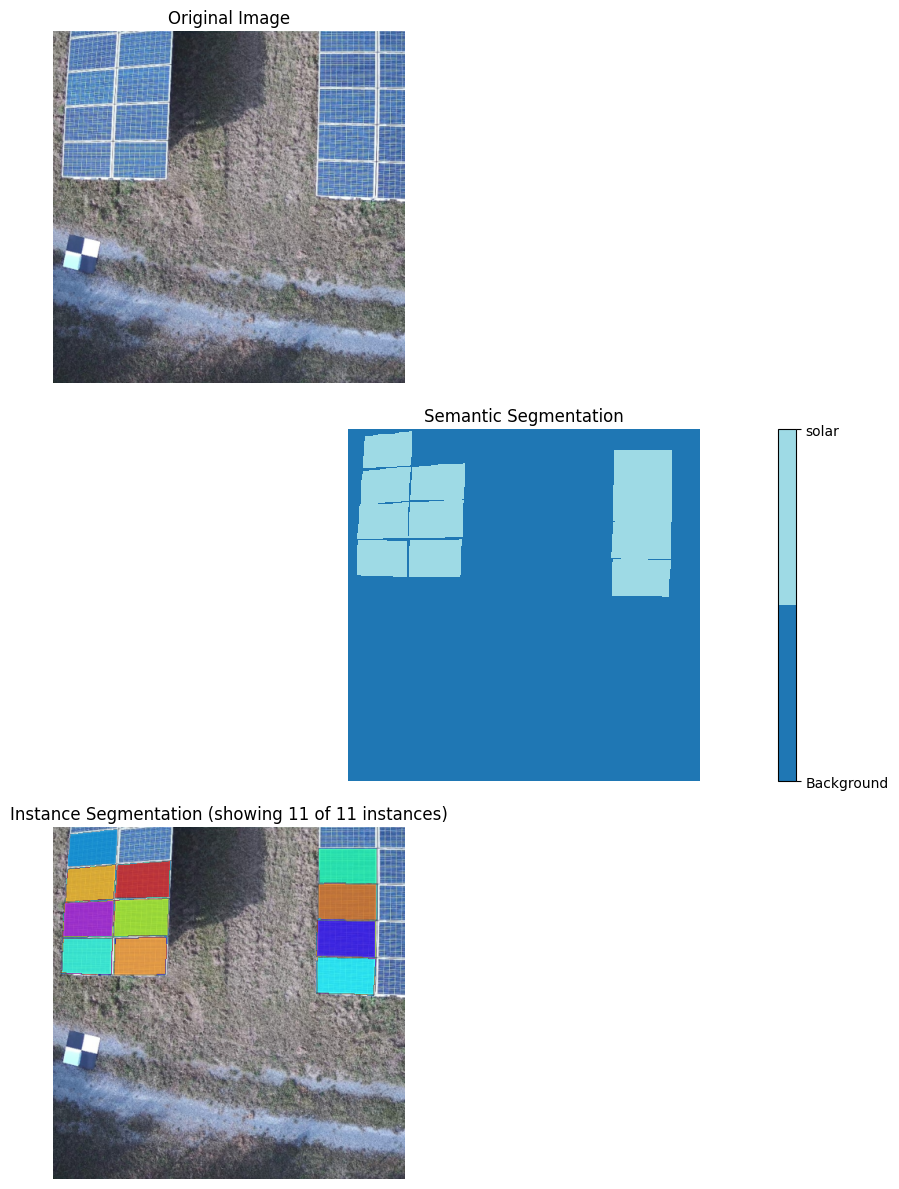

In [148]:
transform, target_transform = create_transforms(target_size=cfg["img_size"])

image_path = "../dataset/solarcoco/imgs"
mask_path = "../dataset/solarcoco/annotations/frame_000003.JSON"
instance_path = "../dataset/solarcoco/instance"


# Create dataset
dataset = COCOInstanceSegmentationDataset(
   coco_json_path = mask_path,
    img_dir = image_path,
    instance_dir = instance_path,
    transform = transform,
    target_transform = target_transform

)




class_names = ["Background", "Class 1", "Class 2", "Class 3"]  # Your class names


batch = next(iter(dataset))

# Visualize just the one-hot instances
fig = dataset.visualize_instance_segmentation(
    batch = batch,
    class_ids=[0,1],
    class_names= ["Background", "solar"]
)

plt.show()


sampler = ImageDuplicateSampler(
        dataset_size=1,
        batch_size=args["batch_size"],
        num_duplicates=args["batch_size"]
    )


# Create dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=args["batch_size"], 
    num_workers=0  # Use 0 for single image to avoid overhead
)



In [6]:
# Create progress bar callback
from pytorch_lightning.callbacks import RichProgressBar
class LossProgressBar(RichProgressBar):
    def __init__(self):
        super().__init__()
        self.losses = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        super().on_train_epoch_end(trainer, pl_module)
        loss = float(trainer.callback_metrics.get('train_loss', 0))
        self.losses.append(loss)
        
progress_bar = LossProgressBar()

# Create model checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='train_loss',
    filename='pasiphae-upernet-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,
    mode='min'
)

# Early stopping callback
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='train_loss',
    patience=10,
    mode='min'
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=200,
    devices=1,
    callbacks=[progress_bar, checkpoint_callback, early_stop_callback],
    logger=True,
    log_every_n_steps=1,
    accelerator = "cuda"
)

# Train model
print("Starting training...")
trainer.fit(pl_model, dataloader)

print("Training complete!")




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ MSRGBConvNeXtUPerNet │ 18.0 M │ train │
│ 1 │ criterion │ CrossEntropyLoss     │      0 │ train │
└───┴───────────┴──────────────────────┴────────┴───────┘

Trainable params: 18.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 18.0 M                                                                                               
Total estimated model params size (MB): 72                                                                         
Modules in train mode: 368                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training complete!


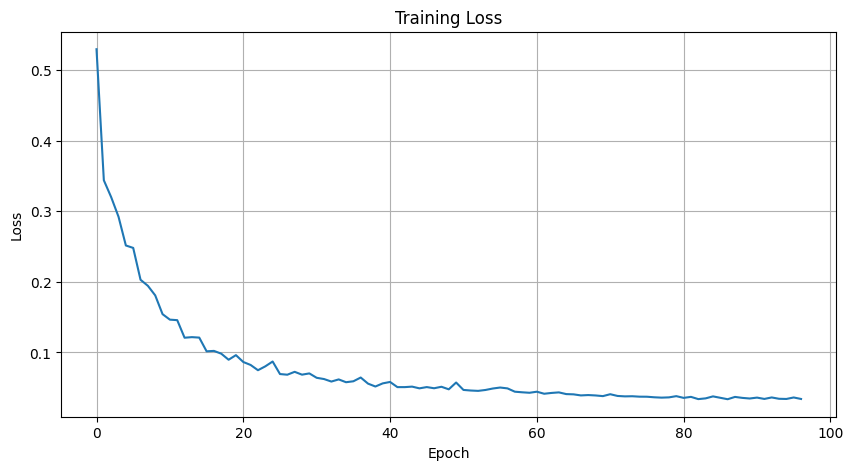

In [7]:
# Plot loss curve
losses = progress_bar.losses
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [11]:
# Save model
model = pl_model.model




In [12]:
# Apply to dataset:
# Create train/val/test datasets
rgb_transform = transforms.Compose([
    transforms.Resize((cfg["img_size"],cfg["img_size"] ), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])


solar_folder = "../dataset/pvhawk" 

non_labeled = LightlyDataset(input_dir = "../dataset/pvhawk",transform=rgb_transform)
non_labeled = torch.utils.data.DataLoader(non_labeled)

In [13]:
# Process all images
num_samples=10
device='cuda'
model.to(device)
all_results = []

model.eval()

for img, idx, img_name in tqdm(iter(non_labeled)):
    img = img.to(device)
    
    with torch.no_grad():
        output = model(rgb  = img)
        
    # Get predicted segmentation mask
    pred_mask = torch.argmax(output, dim=1).cpu().numpy()
    
    # Convert tensor back to PIL image for visualization
    orig_img = img.cpu().squeeze(0)
    # Denormalize
    orig_img = torch.clamp(orig_img, 0, 1)
    
    # Store results
    all_results.append({
        'image': orig_img.permute(1, 2, 0).numpy(),
        'mask': pred_mask[0],
        'filename': img_name[0]
    })
    

# Sample random images
if len(all_results) > num_samples:
    random_samples = random.sample(all_results, num_samples)
else:
    random_samples = all_results
    



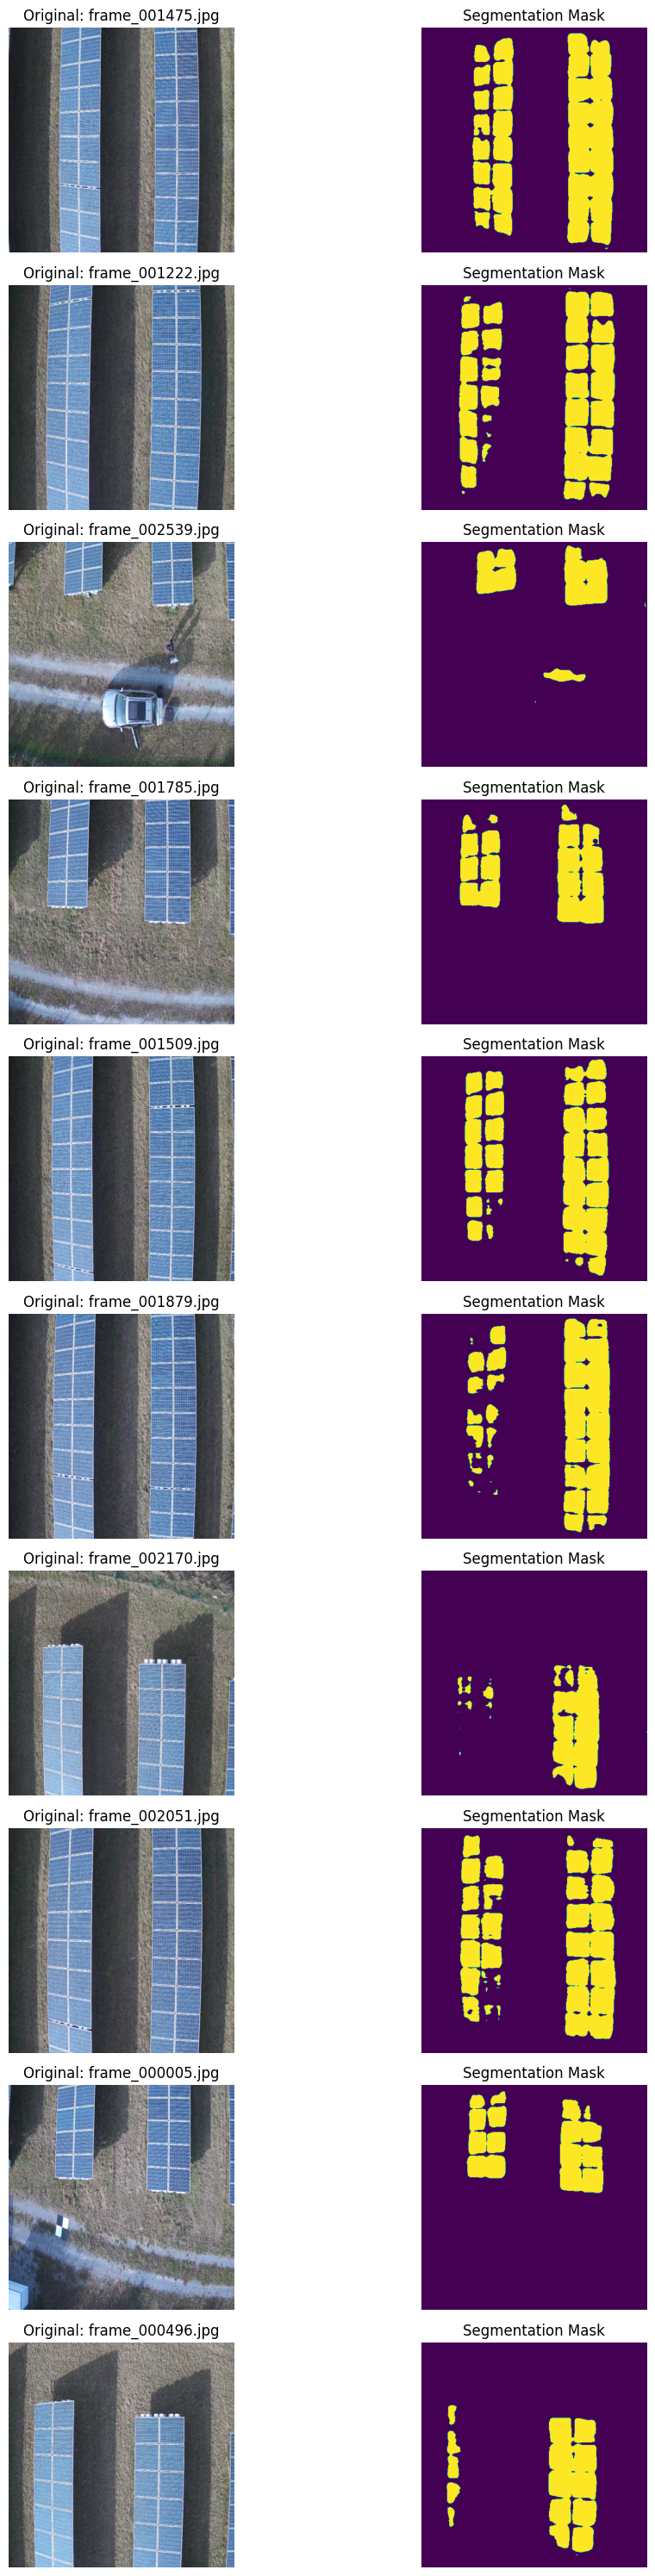

In [14]:
# Visualize the results
def visualize_segmentation(samples):
    fig, axes = plt.subplots(len(samples), 2, figsize=(12, 3*len(samples)))
    
    # If only one sample, wrap axes in a list
    if len(samples) == 1:
        axes = [axes]
    
    for i, sample in enumerate(samples):
        # Original image
        axes[i][0].imshow(sample['image'])
        axes[i][0].set_title(f"Original: {sample['filename']}")
        axes[i][0].axis('off')
        
        # Segmentation mask - using a colormap to make it more visible
        axes[i][1].imshow(sample['mask'], cmap='viridis')
        axes[i][1].set_title(f"Segmentation Mask")
        axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.savefig('segmentation_results.png', dpi=300, bbox_inches='tight')
    plt.show()


visualize_segmentation(random_samples)

In [ ]:


output_path = "model_trained_on_single_image.pth"
torch.save(model.state_dict(), output_path)
print(f"Model saved to {output_path}")
